<!-- PELICAN_BEGIN_SUMMARY -->

To close out our series on building recommendation models using [Sketchfab data]({filename}/2016-10-09-likes-out-guerilla-dataset.md), I will venture far from the [previous]({filename}/2016-10-19-implicit-mf-part-1.md) [posts']({filename}/2016-11-7-implicit-mf-part-2.md) factorization-based methods and instead explore an unsupervised, deep learning-based model. You'll find that the implementation is fairly simple with remarkably promising results which is almost a smack in the face to all of that effort put in earlier.

<!-- PELICAN_END_SUMMARY -->

We are going to build a model-to-model recommender using thumbnail images of 3D [Sketchfab](https://sketchfab.com) models as our input and the *visual similarity* between models as our recommendation score. I was inspired to do this after reading Christopher Bonnett's [post](http://cbonnett.github.io/Insight.html) on product classification, so we will follow a similar approach.

Since our goal is to measure visual similarity, we will need to generate features from our images and then calculate some similarity measure between different images using said features. Back in the day, maybe one would employ fancy wavelets or SIFT keypoints or something for creating features, but this is the Era of Deep Learning and manual feature extraction is for old people. 

Staying on-trend, we will use a pretrained neural network (NN) to extract features. The NN was originally trained to classify images among 1000 labels (e.g. "dog", "train", etc...). We'll chop off the last 3 fully-connected layers of the network which do the final mapping between deep features and class labels and use the fourth-to-last layer as a long feature vector describing our images.

Thankfully, all of this is extremely simple to do with the pretrained models in [Keras](https://keras.io/). Keras allows one to easily build deep learning models on top of either Tensorflow or Theano. Keras also now comes with pretrained models that can be loaded and used. For more information about the available models, visit the [Applications](https://keras.io/applications/) section of the documentation. For our purposes, we'll use the [VGG16](https://keras.io/applications/#vgg16) model because that's what other people seemed to use and I don't know enough to have a compelling reason to stray from the norm.

Our task is now as follows:

1. Load and process images
2. Feed images through NN.
3. Calculate image similarities.
4. Recommend models!

## Load and process images

The first step, which we won't go through here, was to download all of the image thumbnails. There seems to be a standard thumbnail for each Sketchfab model accessible via their API, so I added a function to the [rec-a-sketch](https://github.com/EthanRosenthal/rec-a-sketch) [crawl.py](https://github.com/EthanRosenthal/rec-a-sketch/blob/master/crawl.py) script to automate downloading of all the thumbnails.

Let's load in our libraries and take a look at one of these images.

In [1]:
import csv
import sys
import requests
import skimage.io
import os
import glob
import pickle
import time

from IPython.display import display, Image, HTML
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage
import numpy as np
import pandas as pd
import scipy.sparse as sp
import skimage.io

sys.path.append('../')
import helpers

In [2]:
rand_img = np.random.choice(glob.glob('../data/model_thumbs/*_thumb200.jpg'))

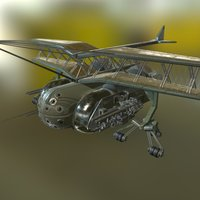

In [3]:
Image(filename=rand_img) 

In [4]:
img = skimage.io.imread(rand_img)
img.shape

(200, 200, 3)

We see that the image can be represented as a 3D matrix through two spatial dimensions (200 x 200) and then a third RGB dimension. We have to do a couple of preprocessing steps before feeding an image through the VGG16 model. The images must be resized to 224 x 224, the color channels must be normalized, and an extra dimension must be added due to Keras expecting to recieve multiple models. Thankfully, Keras has built-in functions to handle most of this.

In [5]:
img = kimage.load_img(rand_img, target_size=(224, 224))
x = kimage.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(x.shape)

(1, 224, 224, 3)


We can now load our model in and try feeding the image through.

In [6]:
# image_top=False removes final connected layers
model = VGG16(include_top=False, weights='imagenet')

In [7]:
pred = model.predict(x)
print(pred.shape)
print(pred.ravel().shape)

(1, 7, 7, 512)
(25088,)


We will later have to flatten the output of the model into a long feature vector. One thing that should be noted is the time that it takes to run a single model though the NN on my 4-core machine:

In [8]:
%%timeit -n5
pred = model.predict(x)

5 loops, best of 3: 905 ms per loop


This is pretty huge when you consider the fact that we will be processing 25,000 images! We'll now go through the above preprocessing steps for every model that we trained in the previous recommender blog posts. We can find these models by importing our "likes" data, filtering out low-interaction models and users (as before), and pick out the models that are leftover.

In [9]:
df = pd.read_csv('../data/model_likes_anon.psv',
                 sep='|', quoting=csv.QUOTE_MINIMAL,
                 quotechar='\\')
df.drop_duplicates(inplace=True)
df = helpers.threshold_interactions_df(df, 'uid', 'mid', 5, 5)

# model_ids to keep
valid_mids = set(df.mid.unique())

## Feed images through NN

With our set of valid model IDs in hand, we can now run through the long process of loading in all of the image files, preprocessing them, and running them through the ```VGG``` prediction. This takes a long time, and certain steps blowup memory. I've decided to batch things up below and include some print statements so that one can track progress. Beware: this takes a long time!

In [10]:
# Grab relevant filenames
get_mid = lambda x: x.split(os.path.sep)[-1].split('_')[0]
fnames = glob.glob('../data/model_thumbs/*_thumb200.jpg')
fnames = [f for f in fnames if get_mid(f) in valid_mids]

idx_to_mid = {}
batch_size = 500
min_idx = 0
max_idx = min_idx + batch_size
total_max = len(fnames)
n_dims = preds.ravel().shape[0]
px = 224

# Initialize predictions matrix
preds = sp.lil_matrix((len(fnames), n_dims))

while min_idx < total_max - 1:
    t0 = time.time()
    
    X = np.zeros(((max_idx - min_idx), px, px, 3))
    
    # For each file in batch, 
    # load as row into X
    for i in range(min_idx, max_idx):
        fname = fnames[i]
        mid = get_mid(fname)
        idx_to_mid[i] = mid
        img = image.load_img(fname, target_size=(px, px))
        img_array = image.img_to_array(img)
        X[i - min_idx, :, :, :] = img_array
        if i % 200 == 0 and i != 0:
            t1 = time.time()
            print('{}: {}'.format(i, (t1 - t0) / i))
            t0 = time.time()
    max_idx = i
    t1 = time.time()
    print('{}: {}'.format(i, (t1 - t0) / i))
    
    print('Preprocess input')
    t0 = time.time()
    X = preprocess_input(X)
    t1 = time.time()
    print('{}'.format(t1 - t0))
    
    print('Predicting')
    t0 = time.time()
    these_preds = model.predict(X)
    shp = ((max_idx - min_idx) + 1, n_dims)
    
    # Place predictions inside full preds matrix.
    preds[min_idx:max_idx + 1, :] = these_preds.reshape(shp)
    t1 = time.time()
    print('{}'.format(t1 - t0))
    
    min_idx = max_idx
    max_idx = np.min((max_idx + batch_size, total_max))

## Calculate image similarities

I would recommend writing the predictions to disk here (don't want the kernel to die and lose all that work!). The ```preds``` matrix consists of a single row for each image with 25,088 sparse features as columns. To calculate item-item recommendations, we must convert this feature matrix into a similarity matrix.

In [11]:
def cosine_similarity(ratings):
    sim = ratings.dot(ratings.T)
    if not isinstance(sim, np.ndarray):
        sim = sim.toarray()
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [12]:
preds = preds.tocsr()
sim = cosine_similarity(preds)

## Recommend models!

Using the similarity matrix, we can reuse some old functions from previous posts to visualize some the recommendations. I've added on some HTML so that clicking on the images links out to their Sketchfab pages. Let's look at a couple!

In [13]:
def get_thumbnails(sim, idx, idx_to_mid, N=10):
    row = sim[idx, :]
    thumbs = []
    mids = []
    for x in np.argsort(-row)[:N]:
        response = requests.get('https://sketchfab.com/i/models/{}'\
                                .format(idx_to_mid[x])).json()
        thumb = [x['url'] for x in response['thumbnails']['images']
                 if x['width'] == 200 and x['height']==200]
        if not thumb:
            print('no thumbnail')
        else:
            thumb = thumb[0]
        thumbs.append(thumb)
        mids.append(idx_to_mid[x])
    return thumbs, mids

def display_thumbs(thumbs, mids, N=5):
    thumb_html = "<a href='{}' target='_blank'>\
                  <img style='width: 160px; margin: 0px; \
                  float: left; border: 1px solid black; display:inline-block' \
                  src='{}' /></a>"
    images = "<div class='line' style='max-width: 640px; display: block;'>"

    display(HTML('<font size=5>'+'Input Model'+'</font>'))
    link = 'http://sketchfab.com/models/{}'.format(mids[0])
    url = thumbs[0]
    display(HTML(thumb_html.format(link, url)))
    display(HTML('<font size=5>'+'Similar Models'+'</font>'))

    for (url, mid) in zip(thumbs[1:N+1], mids[1:N+1]):
        link = 'http://sketchfab.com/models/{}'.format(mid)
        images += thumb_html.format(link, url)

    images += '</div>'
    display(HTML(images))

In [14]:
display_thumbs(*get_thumbnails(sim, 100, idx_to_mid, N=10), N=9)

In [15]:
display_thumbs(*get_thumbnails(sim, 1000, idx_to_mid, N=10), N=9)

In [16]:
display_thumbs(*get_thumbnails(sim, 1492, idx_to_mid, N=10), N=9)

## Conclusion

Wow! With this completely unsupervised method and zero hyperparameter tuning, we get strikingly well-matched images. This might feel somewhat frustrating - why did we spend all that time with those math-heavy, brain-stretching factorization algorithms when we could just feed everything through a deep learning model? Firstly, it may be difficult to perform user-to-item recommendations or the tag-recommendations from last post. Secondly, it seems that this visual similarity model and the implicit feedback models serve different purposes. 

The NN does exactly what we expect - it finds similar images. The implicit feedback model finds other models that similar users have liked. What tends to happen is that the likes-based recommendations find models that share similar themes or appeal to certain clusters of users. For example, we may see that various anime characters get grouped together, or renderings of medieval armor and weapons. If we were to feed one of the medieval weapons into the NN, then we would find other examples of *only* that exact weapon which likely span across many periods of time.

I did attempt to combine the LightFM model with this NN model by taking the NN output features and using them as side information in the LightFM model. There were typically ~2500 nonzero NN features for each model which totally blew up the training time of the LightFM model. It took 30 minutes to compute the precision at k. I shuttered at the idea of calculating learning curves and grid searches, so I gave up! Maybe someday I'll spin up a giant EC2 box and see what happens.

Next post, I wrap up this series by writing about how I built out a Flask app on AWS called Rec-a-Sketch to serve up interactive Sketchfab recommendations. Thanks for reading!